# DATA INTIALIZATION 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# Data-set Loading from library 
file_path = 'loan.csv' 
loan_data = pd.read_csv(file_path,low_memory =False) #to optimize memory usage while reading large files

# DATA CLEANING AND MANUPULATION 

## Initial Data Exploration

In [ ]:
# S1: Drop columns were values are 100% missing 
missing_values_percent = loan_data.isnull().mean() * 100
columns_to_drop = missing_values_percent[missing_values_percent == 100.0].index
loan_data_cleaned = loan_data.drop(columns=columns_to_drop)

# S2: Convert 'int_rate' column from string to float by removing '%' sign
loan_data_cleaned['int_rate'] = loan_data_cleaned['int_rate'].str.rstrip('%').astype(float)

# S3: Assign missing values
# Divide numeric and categorical columns separatly 
numeric_columns = loan_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = loan_data_cleaned.select_dtypes(include=['object']).columns

# Suffuse missing values in numeric columns with median
loan_data_cleaned[numeric_columns] = loan_data_cleaned[numeric_columns].fillna(loan_data_cleaned[numeric_columns].median())

# Suffuse missing values in categorical columns with mode
loan_data_cleaned[categorical_columns] = loan_data_cleaned[categorical_columns].fillna(loan_data_cleaned[categorical_columns].mode().iloc[0])

# S4: Check for duplicates and delete them
loan_data_cleaned.drop_duplicates(inplace=True)

## Handling Missing Values and Outliers 

In [ ]:

# S1: Handling Outliers using IQR method
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap floor outliers
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

# Apply outlier handling to numeric columns
for col in numeric_columns:
    handle_outliers(loan_data_cleaned, col)


# S2: Check for duplicates and remove them
loan_data_cleaned.drop_duplicates(inplace=True)

# Load your cleaned dataset (assuming that above cleaning steps were already performed)
loan_data_cleaned = pd.read_csv(file_path, low_memory=False)

## Feature Engineering

In [ ]:

# S1: Extract features from the 'term' column (convert '36 months' or '60 months' into an integer)
loan_data_cleaned['term'] = loan_data_cleaned['term'].str.extract(r'(\d+)').astype(int)

# S2: Create interaction features
# For example, loan_amnt to annual_inc ratio
if 'annual_inc' in loan_data_cleaned.columns:
    loan_data_cleaned['loan_inc_ratio'] = loan_data_cleaned['loan_amnt'] / loan_data_cleaned['annual_inc']

# S3: Fetch date-related features from a date column (if present, e.g., 'issue_d')
# Convert 'issue_d' to datetime and extract year and month
if 'issue_d' in loan_data_cleaned.columns:
    loan_data_cleaned['issue_d'] = pd.to_datetime(loan_data_cleaned['issue_d'], format='%b %d, %y', errors='coerce')
    loan_data_cleaned['issue_year'] = loan_data_cleaned['issue_d'].dt.year
    loan_data_cleaned['issue_month'] = loan_data_cleaned['issue_d'].dt.month

# S5: Create a debt-to-income (DTI) ratio feature
# If 'annual_inc' and 'loan_amnt' columns exist, DTI (Debt-to-income) ratio can be created as follows
if 'annual_inc' in loan_data_cleaned.columns and 'loan_amnt' in loan_data_cleaned.columns:
    loan_data_cleaned['dti'] = loan_data_cleaned['loan_amnt'] / loan_data_cleaned['annual_inc']


# UNIVARIANT ANALYSIS

In [ ]:
# S1: Summary statistics for numerical variables
numerical_summary = loan_data_cleaned.describe()

# S2: Frequency counts for categorical variables
categorical_columns = loan_data_cleaned.select_dtypes(include=['object']).columns
categorical_summary = {}

for col in categorical_columns:
    categorical_summary[col] = loan_data_cleaned[col].value_counts()

# S3: Visualization for numerical variables (histogram and boxplot)
def plot_numerical_variable(data, column):
    plt.figure(figsize=(14, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f"Histogram of {column}")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data[column])
    plt.title(f"Boxplot of {column}")

    plt.show()


# S4: Visualization for categorical variables (bar chart)
def plot_categorical_variable(data, column):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=column, data=data, order=data[column].value_counts().index)
    plt.title(f"Countplot of {column}")
    plt.xticks(rotation=90)
    plt.show()



# Visualize univariate analysis for a specific numeric variable, e.g., 'loan_amnt'
plot_numerical_variable(loan_data_cleaned, 'loan_amnt')

# Visualize univariate analysis for a specific categorical variable, e.g., 'loan_status'
plot_categorical_variable(loan_data_cleaned, 'loan_status')

# Final Outputs: Display summary
print("Numerical Summary Statistics:")
print(numerical_summary)

print("\nCategorical Value Counts:")
for col, counts in categorical_summary.items():
    print(f"\n{col}:\n{counts}")

# BIVARIANT ANALYSIS 

In [11]:

# S1: Numeric-Numeric Relationship
# Correlation matrix and heatmap
def plot_correlation_matrix(data, numerical_columns):
    corr_matrix = data[numerical_columns].corr()
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title("Correlation Matrix")
    plt.show()

# Scatter plot between two numeric variables
def plot_scatter(data, x_var, y_var):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=x_var, y=y_var, data=data)
    plt.title(f"Scatter Plot: {x_var} vs {y_var}")
    plt.show()

# S2: Categorical-Categorical Relationship
# Cross-tabulation and heatmap
def plot_crosstab_heatmap(data, cat1, cat2):
    crosstab = pd.crosstab(data[cat1], data[cat2])
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(crosstab, annot=True, cmap='Blues', linewidths=0.5)
    plt.title(f"Cross Tabulation Heatmap: {cat1} vs {cat2}")
    plt.show()

# S3: Numeric-Categorical Relationship
# Boxplot between a numeric variable and a categorical variable
def plot_boxplot(data, cat_var, num_var):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cat_var, y=num_var, data=data)
    plt.title(f"Box Plot: {num_var} by {cat_var}")
    plt.xticks(rotation=90)
    plt.show()

# Violin plot for more detailed distribution
def plot_violinplot(data, cat_var, num_var):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x=cat_var, y=num_var, data=data)
    plt.title(f"Violin Plot: {num_var} by {cat_var}")
    plt.xticks(rotation=90)
    plt.show()
# Define a function to clean percentage columns
def clean_percentage_column(column):
    # Convert values to strings, remove '%' if present, then convert to float
    return pd.to_numeric(column.str.rstrip('%'), errors='coerce') / 100.0

# Apply the function to the relevant percentage columns
percentage_columns = ['int_rate', 'revol_util']  # Replace with your actual column names

# Loop through the columns and apply the cleaning function
for column in percentage_columns:
    if column in loan_data_cleaned.columns:
        loan_data_cleaned[column] = clean_percentage_column(loan_data_cleaned[column])
        print(f"Cleaned column: {column}")

# Check for missing values after conversion
print(loan_data_cleaned[percentage_columns].isnull().sum())

Cleaned column: int_rate
Cleaned column: revol_util
int_rate       0
revol_util    50
dtype: int64


## Numeric-Numeric Analysis: Correlation and scatter plot

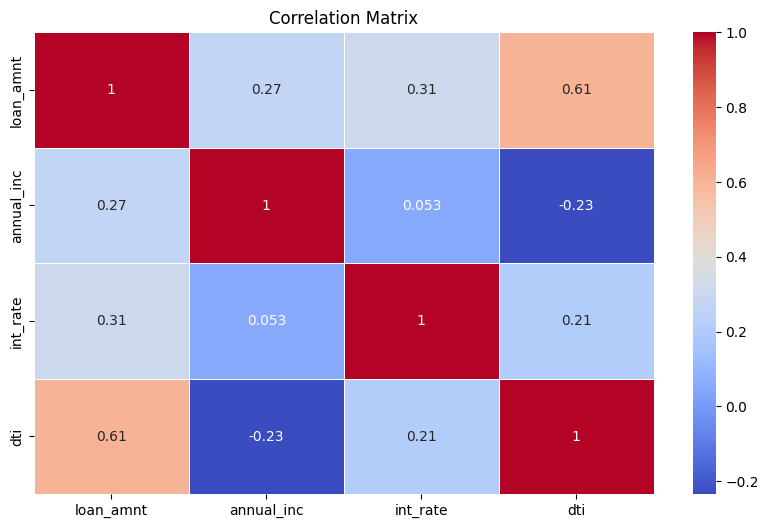

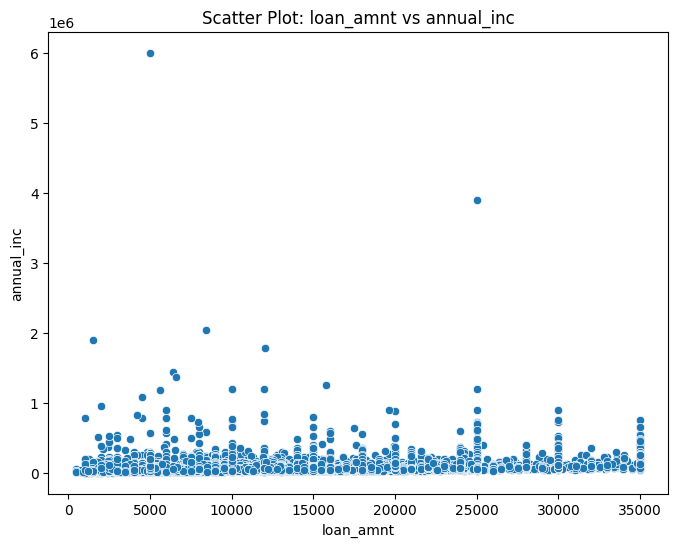

In [12]:
# Numeric-Numeric Analysis: Correlation and scatter plot
numerical_columns = ['loan_amnt', 'annual_inc', 'int_rate', 'dti']  # Specify the relevant numeric columns
plot_correlation_matrix(loan_data_cleaned, numerical_columns)
plot_scatter(loan_data_cleaned, 'loan_amnt', 'annual_inc')  # Example of scatter plot

## Categorical-Categorical Analysis: Cross-tabulation and heatmap

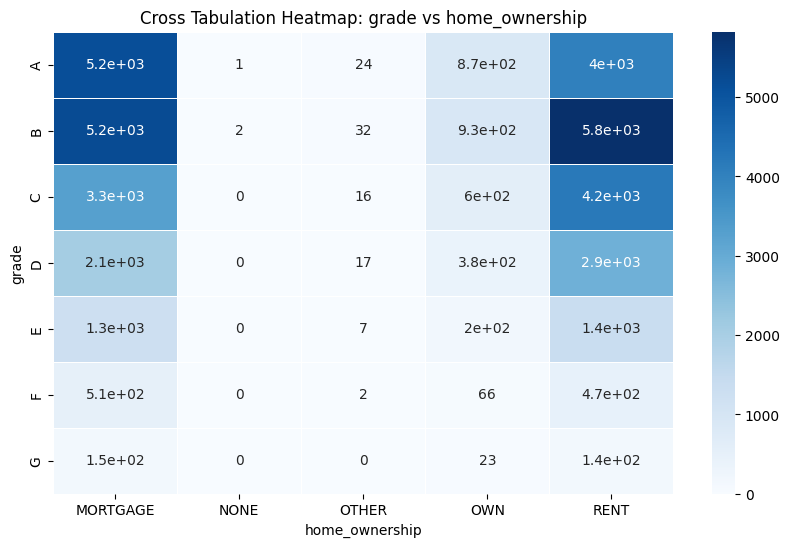

In [13]:
# Categorical-Categorical Analysis: Cross-tabulation and heatmap
plot_crosstab_heatmap(loan_data_cleaned, 'grade', 'home_ownership')  # Example of categorical relationship


## Numeric-Categorical Analysis: Box plot and violin plot

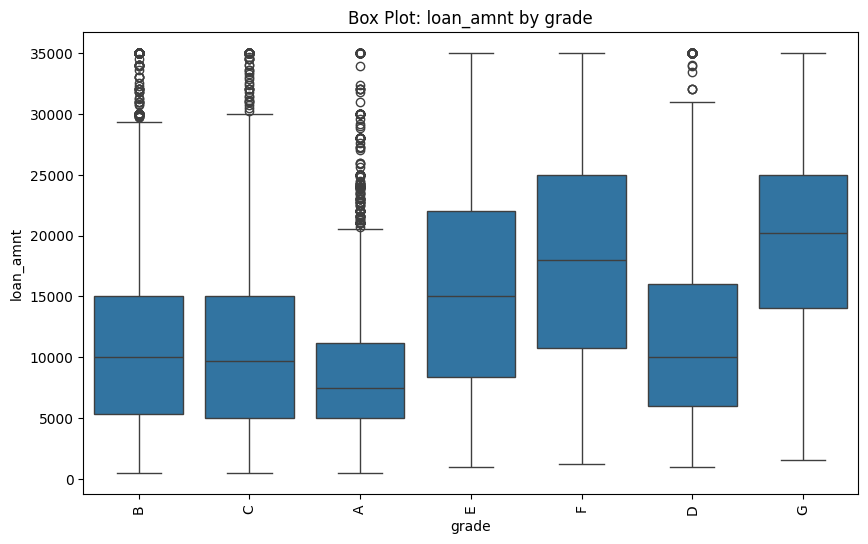

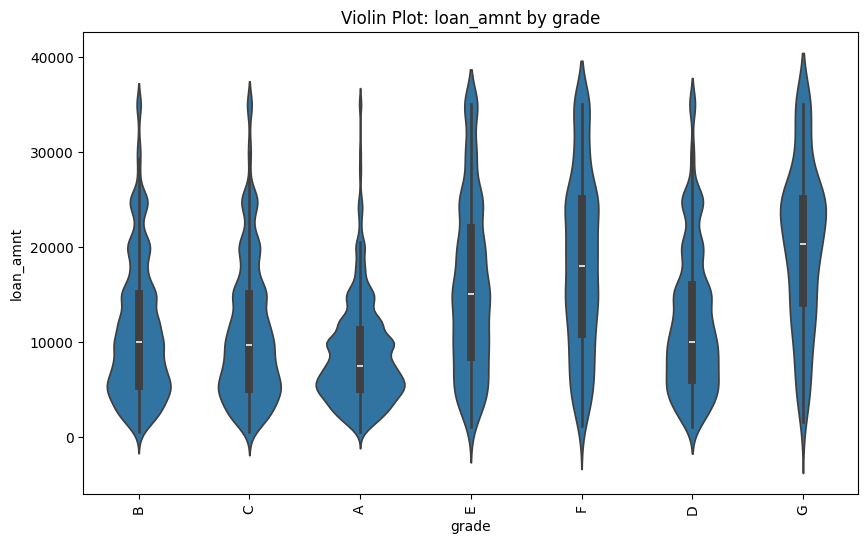

Correlation Matrix for Numeric Columns:
            loan_amnt  annual_inc  int_rate       dti
loan_amnt    1.000000    0.271149  0.309415  0.605897
annual_inc   0.271149    1.000000  0.053185 -0.234495
int_rate     0.309415    0.053185  1.000000  0.212299
dti          0.605897   -0.234495  0.212299  1.000000


In [15]:
# Numeric-Categorical Analysis: Box plot and violin plot
plot_boxplot(loan_data_cleaned, 'grade', 'loan_amnt')  # Example of box plot
plot_violinplot(loan_data_cleaned, 'grade', 'loan_amnt')  # Example of violin plot
# Output the correlation matrix
print("Correlation Matrix for Numeric Columns:")
print(loan_data_cleaned[numerical_columns].corr())

# CORRELATION MATRIX

In [ ]:
# S1: Compute the correlation matrix for numeric columns
numeric_columns = loan_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = loan_data_cleaned[numeric_columns].corr()


# S2: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(24, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


In [18]:
# Optional: If you want to filter for high correlations (absolute value > 0 for example)
high_corr = correlation_matrix[abs(correlation_matrix) > 0]
print("High Correlation Matrix (absolute value > 0):")
print(high_corr)

High Correlation Matrix (absolute value > 0):
                                  id  member_id  loan_amnt  funded_amnt  \
id                          1.000000   0.993650   0.141919     0.152286   
member_id                   0.993650   1.000000   0.140710     0.150322   
loan_amnt                   0.141919   0.140710   1.000000     0.981578   
funded_amnt                 0.152286   0.150322   0.981578     1.000000   
funded_amnt_inv             0.249547   0.257887   0.940034     0.958422   
...                              ...        ...        ...          ...   
total_bc_limit                   NaN        NaN        NaN          NaN   
total_il_high_credit_limit       NaN        NaN        NaN          NaN   
loan_inc_ratio              0.097435   0.095824   0.605897     0.594277   
issue_year                       NaN        NaN        NaN          NaN   
issue_month                      NaN        NaN        NaN          NaN   

                            funded_amnt_inv  int_rate

# TIME-BASED ANALYSIS 

In [30]:

# S1: Ensure the date column is in datetime format
# Assuming 'issue_d' is the relevant date column
if 'issue_d' in loan_data_cleaned.columns:
    loan_data_cleaned['issue_d'] = pd.to_datetime(loan_data_cleaned['issue_d'], format='%b %d, %y', errors='coerce')
# Step 2: Extract time-based features (Year, Month, Quarter)
loan_data_cleaned['issue_year'] = loan_data_cleaned['issue_d'].dt.year
loan_data_cleaned['issue_month'] = loan_data_cleaned['issue_d'].dt.month
loan_data_cleaned['issue_quarter'] = loan_data_cleaned['issue_d'].dt.quarter


## Data Intialisation Before Plotting 

In [34]:
import pandas as pd
import numpy as np

# Assuming loan_data_cleaned is your DataFrame

print("DataFrame Info:")
print(loan_data_cleaned.info())

print("\nFirst few rows of the DataFrame:")
print(loan_data_cleaned.head())

# Check for relevant columns
relevant_columns = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'grade', 'sub_grade', 'term']
missing_columns = [col for col in relevant_columns if col not in loan_data_cleaned.columns]

if missing_columns:
    print(f"\nWarning: The following columns are missing: {missing_columns}")

# Basic statistical analysis
print("\nBasic Statistical Analysis:")
print(loan_data_cleaned[relevant_columns].describe())

# Loan amount analysis
if 'loan_amnt' in loan_data_cleaned.columns:
    print("\nLoan Amount Distribution:")
    print(loan_data_cleaned['loan_amnt'].value_counts(bins=5, normalize=True).sort_index())

# Interest rate analysis
if 'int_rate' in loan_data_cleaned.columns:
    print("\nInterest Rate Distribution:")
    print(loan_data_cleaned['int_rate'].value_counts(bins=5, normalize=True).sort_index())

# Grade analysis
if 'grade' in loan_data_cleaned.columns:
    print("\nLoan Grade Distribution:")
    print(loan_data_cleaned['grade'].value_counts(normalize=True))

# Term analysis
if 'term' in loan_data_cleaned.columns:
    print("\nLoan Term Distribution:")
    print(loan_data_cleaned['term'].value_counts(normalize=True))

# Correlation analysis
print("\nCorrelation Matrix:")
numeric_columns = loan_data_cleaned.select_dtypes(include=[np.number]).columns
correlation_matrix = loan_data_cleaned[numeric_columns].corr()
print(correlation_matrix)

# Top correlations
print("\nTop 10 Correlations:")
correlations = correlation_matrix.unstack()
correlations = correlations[correlations != 1.0]  # Remove self-correlations
top_correlations = correlations.abs().sort_values(ascending=False).head(10)
print(top_correlations)

print("\nNote: Due to issues with the 'issue_d' column, time-based analysis could not be performed.")

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 115 entries, id to issue_quarter
dtypes: datetime64[ns](1), float64(80), int32(1), int64(13), object(20)
memory usage: 34.7+ MB
None

First few rows of the DataFrame:
        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  term  \
0  1077501    1296599       5000         5000           4975.0    36   
1  1077430    1314167       2500         2500           2500.0    60   
2  1077175    1313524       2400         2400           2400.0    36   
3  1076863    1277178      10000        10000          10000.0    36   
4  1075358    1311748       3000         3000           3000.0    60   

   int_rate  installment grade sub_grade  ... pub_rec_bankruptcies tax_liens  \
0    0.1065       162.87     B        B2  ...                  0.0       0.0   
1    0.1527        59.83     C        C4  ...                  0.0       0.0   
2    0.1596        84.33     C        C5  ...              

## Data Plotting

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 115 entries, id to issue_quarter
dtypes: datetime64[ns](1), float64(80), int32(1), int64(13), object(20)
memory usage: 34.7+ MB
None

First few rows of the DataFrame:
        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv  term  \
0  1077501    1296599       5000         5000           4975.0    36   
1  1077430    1314167       2500         2500           2500.0    60   
2  1077175    1313524       2400         2400           2400.0    36   
3  1076863    1277178      10000        10000          10000.0    36   
4  1075358    1311748       3000         3000           3000.0    60   

   int_rate  installment grade sub_grade  ... pub_rec_bankruptcies tax_liens  \
0    0.1065       162.87     B        B2  ...                  0.0       0.0   
1    0.1527        59.83     C        C4  ...                  0.0       0.0   
2    0.1596        84.33     C        C5  ...              

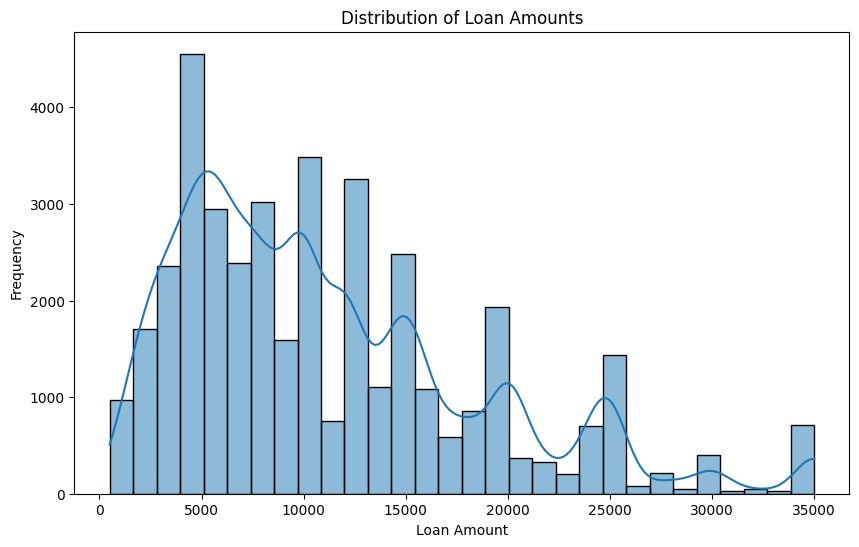


Interest Rate Distribution:


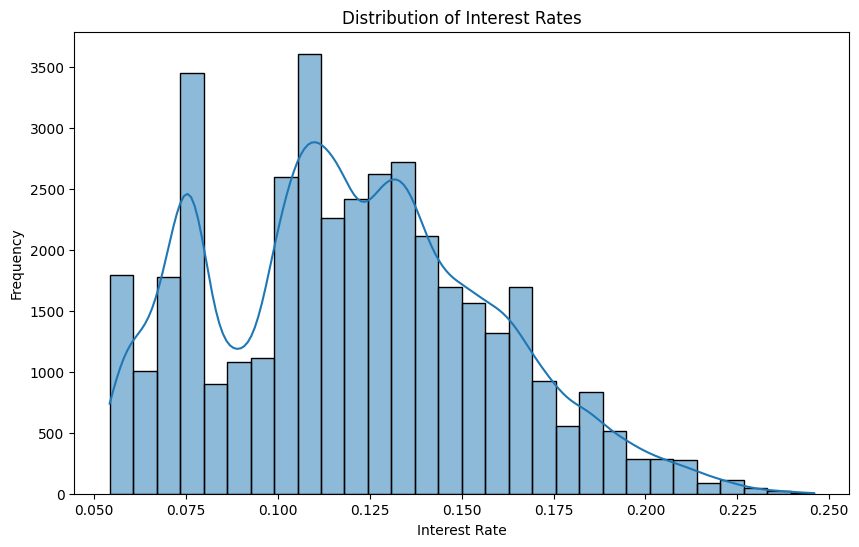


Loan Grade Distribution:


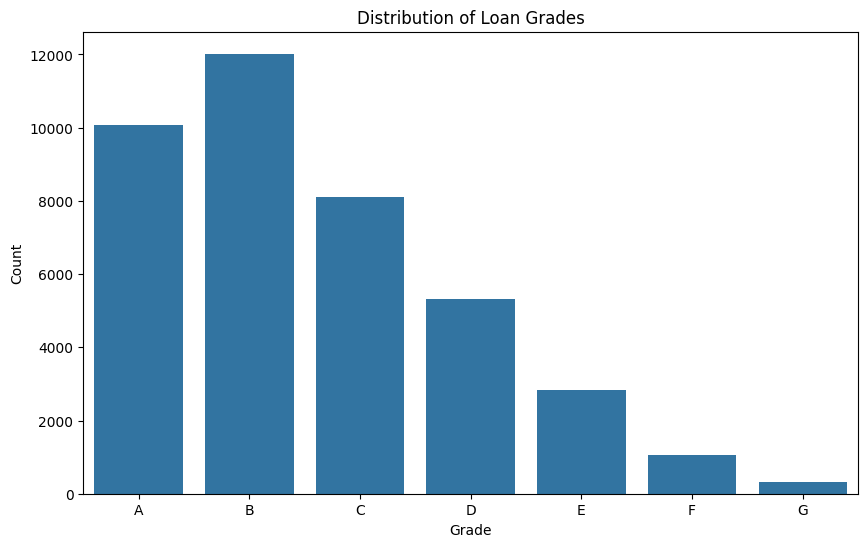


Loan Term Distribution:


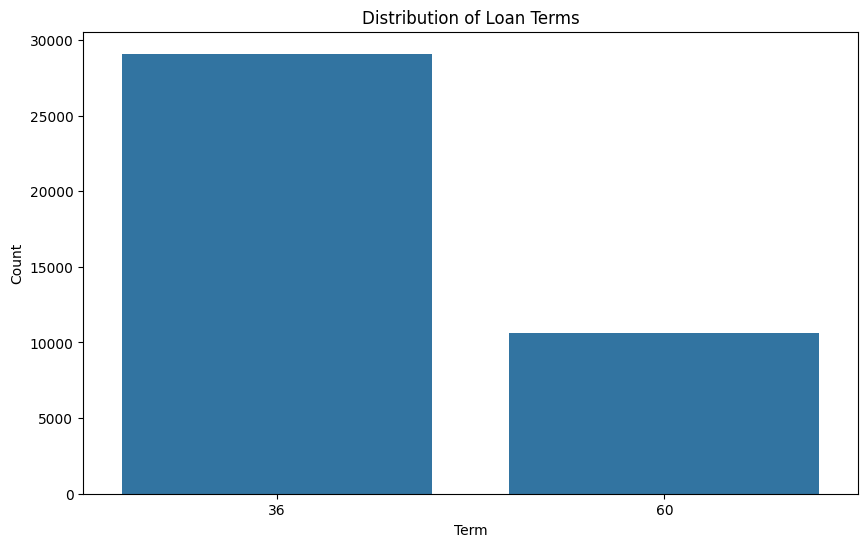


Correlation Matrix:


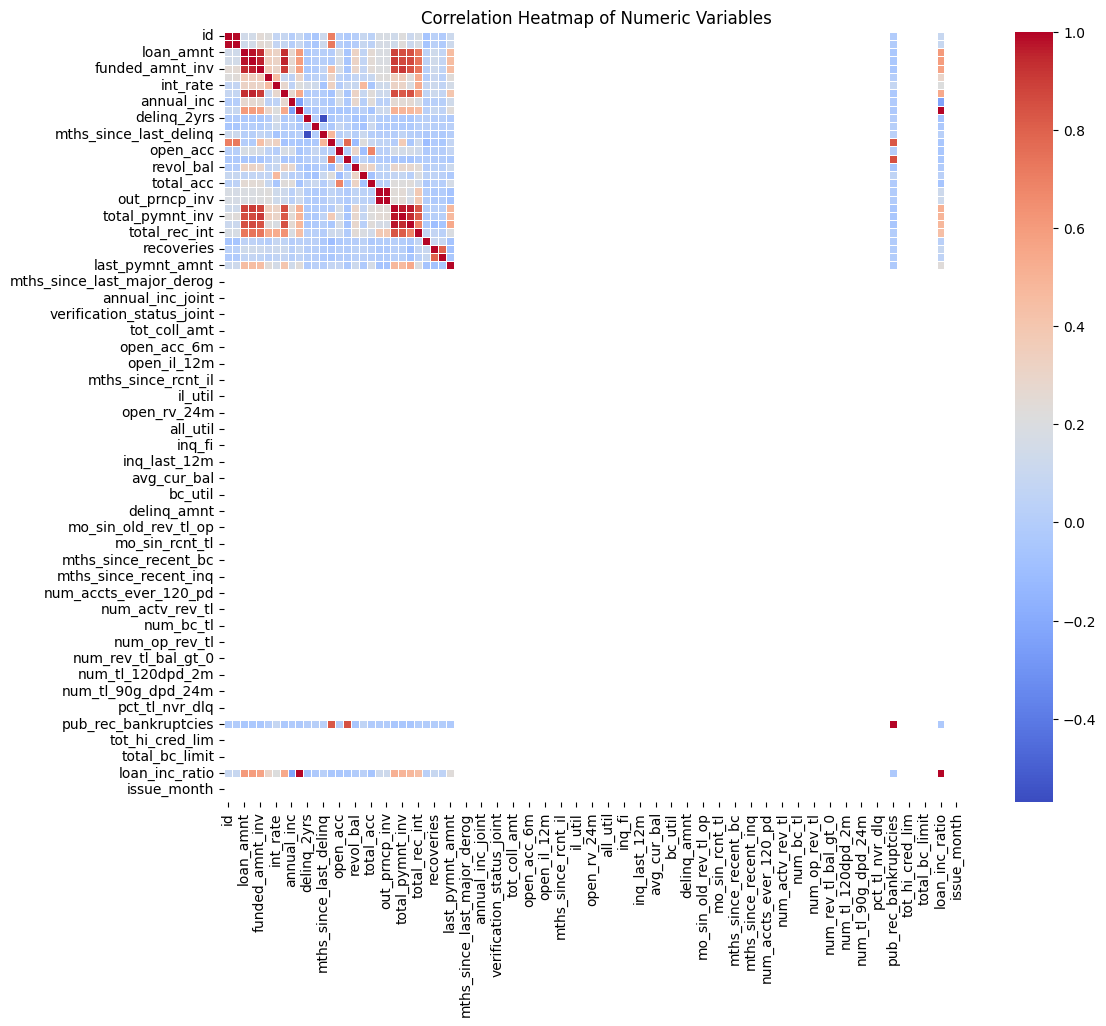


Top 10 Correlations:
out_prncp        out_prncp_inv      0.999827
out_prncp_inv    out_prncp          0.999827
id               member_id          0.993650
member_id        id                 0.993650
funded_amnt      loan_amnt          0.981578
loan_amnt        funded_amnt        0.981578
total_rec_prncp  total_pymnt        0.971472
total_pymnt      total_rec_prncp    0.971472
total_pymnt_inv  total_pymnt        0.970815
total_pymnt      total_pymnt_inv    0.970815
dtype: float64


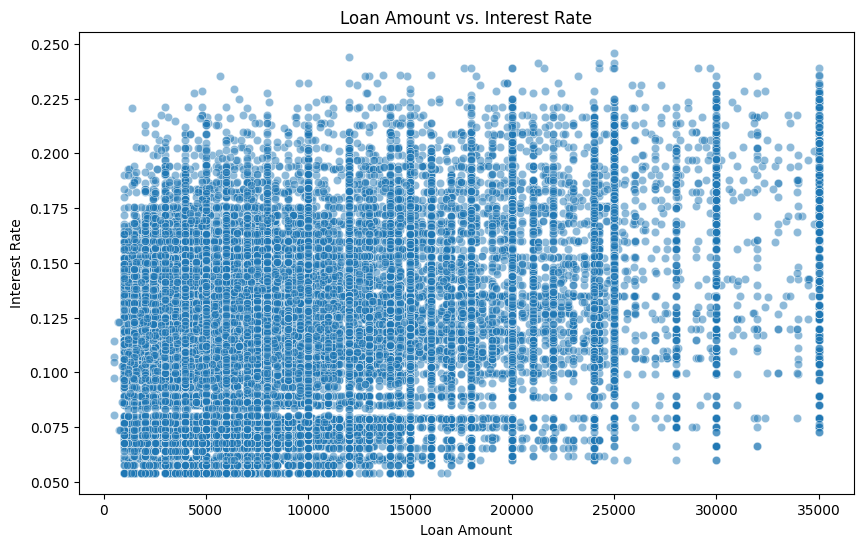

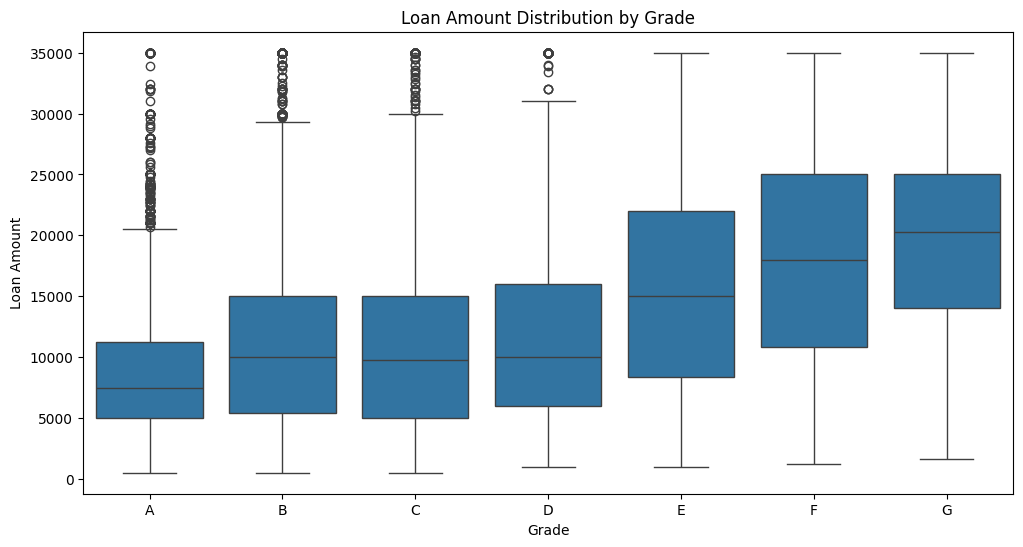


Note: Due to issues with the 'issue_d' column, time-based analysis could not be performed.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming loan_data_cleaned is your DataFrame

print("DataFrame Info:")
print(loan_data_cleaned.info())

print("\nFirst few rows of the DataFrame:")
print(loan_data_cleaned.head())

# Check for relevant columns
relevant_columns = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'grade', 'sub_grade', 'term']
missing_columns = [col for col in relevant_columns if col not in loan_data_cleaned.columns]

if missing_columns:
    print(f"\nWarning: The following columns are missing: {missing_columns}")

# Basic statistical analysis
print("\nBasic Statistical Analysis:")
print(loan_data_cleaned[relevant_columns].describe())

# Loan amount analysis
if 'loan_amnt' in loan_data_cleaned.columns:
    print("\nLoan Amount Distribution:")
    plt.figure(figsize=(10, 6))
    sns.histplot(loan_data_cleaned['loan_amnt'], kde=True, bins=30)
    plt.title('Distribution of Loan Amounts')
    plt.xlabel('Loan Amount')
    plt.ylabel('Frequency')
    plt.show()

# Interest rate analysis
if 'int_rate' in loan_data_cleaned.columns:
    print("\nInterest Rate Distribution:")
    plt.figure(figsize=(10, 6))
    sns.histplot(loan_data_cleaned['int_rate'], kde=True, bins=30)
    plt.title('Distribution of Interest Rates')
    plt.xlabel('Interest Rate')
    plt.ylabel('Frequency')
    plt.show()

# Grade analysis
if 'grade' in loan_data_cleaned.columns:
    print("\nLoan Grade Distribution:")
    plt.figure(figsize=(10, 6))
    sns.countplot(x='grade', data=loan_data_cleaned, order=sorted(loan_data_cleaned['grade'].unique()))
    plt.title('Distribution of Loan Grades')
    plt.xlabel('Grade')
    plt.ylabel('Count')
    plt.show()

# Term analysis
if 'term' in loan_data_cleaned.columns:
    print("\nLoan Term Distribution:")
    plt.figure(figsize=(10, 6))
    sns.countplot(x='term', data=loan_data_cleaned)
    plt.title('Distribution of Loan Terms')
    plt.xlabel('Term')
    plt.ylabel('Count')
    plt.show()

# Correlation analysis
print("\nCorrelation Matrix:")
numeric_columns = loan_data_cleaned.select_dtypes(include=[np.number]).columns
correlation_matrix = loan_data_cleaned[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

# Top correlations
print("\nTop 10 Correlations:")
correlations = correlation_matrix.unstack()
correlations = correlations[correlations != 1.0]  # Remove self-correlations
top_correlations = correlations.abs().sort_values(ascending=False).head(10)
print(top_correlations)

# Scatter plot of loan amount vs. interest rate
if 'loan_amnt' in loan_data_cleaned.columns and 'int_rate' in loan_data_cleaned.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='loan_amnt', y='int_rate', data=loan_data_cleaned, alpha=0.5)
    plt.title('Loan Amount vs. Interest Rate')
    plt.xlabel('Loan Amount')
    plt.ylabel('Interest Rate')
    plt.show()

# Box plot of loan amount by grade
if 'loan_amnt' in loan_data_cleaned.columns and 'grade' in loan_data_cleaned.columns:
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='grade', y='loan_amnt', data=loan_data_cleaned, order=sorted(loan_data_cleaned['grade'].unique()))
    plt.title('Loan Amount Distribution by Grade')
    plt.xlabel('Grade')
    plt.ylabel('Loan Amount')
    plt.show()

print("\nNote: Due to issues with the 'issue_d' column, time-based analysis could not be performed.")

# Summary

## shot summary on output results
dataset contains 39,717 records with 111 columns. 

Here is a brief summary:

Loan Amount (loan_amnt):

Range: 500 to 35,000

Mean: 11,219

25th Percentile: 5,500

75th Percentile: 15,000

Funded Amount (funded_amnt): Similar to loan amount, with a mean of 10,947.

Interest Rate (int_rate): 371 unique interest rates, most common is 10.99%.

Term: Either 36 months (29,096 loans) or 60 months.

Installment:

Mean: 324.56

Range: 15.69 to 1,305.19

Grade: Loans are categorized into seven grades (A to G), with B being the most frequent.

## Detailed summary on the methods used to fetch results
Several columns contain missing or incomplete data we clean the data using handling missing values and outliers to make the datasheet more accessable for plotting and fetching results.  

Next we compare the interest rates (int_rate), annaul income (annaul_inc) and loan amount (loan_amt) to plot graphs (bar, box, violin and histogram)  and fetch data categorically. 

Later we genarate usfull comparision between interest rates (int_rate), annaul income (annaul_inc), DTI and loan amount (loan_amt) using a correlation matrix 
1. Loan_amnt and funded_amnt: Correlation of 0.98, indicating that the requested loan amount and the funded amount are almost identical.
2. Loan_amnt and funded_amnt_inv: Correlation of 0.94, showing a strong relationship between the loan amount and the invested amount.
3. Installment is strongly correlated with loan_amnt (0.93), which makes sense since installment payments are determined by the loan size.

Finally we perform time based analysis to analyse Grade, Term, Interest Rate, Loan amount and genrate best correlations by comparing 
1. Loan amount vs Interest rate using scatter plot
2. Load amount and grade using box plot


Results: 

Range: 500 to 35,000

Mean: 11,219

25th Percentile: 5,500

75th Percentile: 15,000